# Inferring Lorenz system with SINDy
***
Created by: Juan Felipe Osorio Ramirez

Department of Applied Mathematics, UW
***

Given a set of measurements $x(t)\in \mathbb{R}^3$ from the Lorenz system at different points in time $t\in 0:0.001:100$. We will use SINDy to represent the time evolution of $x(t)$ in terms of a nonlinear function $f$:

$$ \frac{d}{dt}x(t) = f(x(t)). $$

Explicitely, we wish to find the system
$$
\begin{align}
\dot{x} &= \sigma(y-x) \\
\dot{y} &= x(\rho-z)-y \\
\dot{z} &= xy - \beta z
\end{align}
$$
where $\sigma = 10$, $\rho=28$, and $\beta = 8/3$.

## Libraries

Installation of `PySINDy`

In [1]:
!pip3 install pysindy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 7.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

## Utils

### Plotting

In [3]:
def myplot3d(X_true,X_pred):
  mse = mean_squared_error(X_true,X_pred) / mean_squared_error(X_true,0*X_pred)
  # set up a figure twice as wide as it is tall
  fig = plt.figure(figsize=plt.figaspect(0.5))
  fig.suptitle('Normalized MSE: {}'.format(mse))
  # =============
  # First subplot
  # =============
  # set up the axes for the first plot
  ax = fig.add_subplot(1, 2, 1, projection='3d')
  ax.plot3D(x, y, z, 'green', linewidth= 0.2, )
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.set_title('True solution')
  # plot a 3D surface like in the example mplot3d/surface3d_demo


  # ==============
  # Second subplot
  # ==============
  # set up the axes for the second plot
  ax = fig.add_subplot(1, 2, 2, projection='3d')

  # plot a 3D wireframe like in the example mplot3d/wire3d_demo
  ax.plot3D(sim[:,0], sim[:,1], sim[:,2], 'green', linewidth= 0.2, )
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_zlabel('z')
  ax.set_title('Predicted solution')

  plt.show()
  return None

In [4]:
def myplot(t,x,sim,t_max, variable):
  if variable == 'x':
    plt.plot(t[:t_max], x[:t_max], label ='true')
    plt.plot(t[:t_max], sim[:t_max,0], '-.', label ='pred')
  if variable == 'y':
    plt.plot(t[:t_max], y[:t_max], label ='true')
    plt.plot(t[:t_max], sim[:t_max,1], '-.', label ='pred')
  if variable == 'z':
    plt.plot(t[:t_max], z[:t_max], label ='true')
    plt.plot(t[:t_max], sim[:t_max,2], '-.', label ='pred')
  plt.xlabel("t")
  plt.ylabel("{}".format(variable))
  plt.legend()
  plt.title('{}-variable true values vs. predictions'.format(variable))
  plt.show()

  return None

## Method

### Data setup

Load observed data

In [5]:
data = np.loadtxt("xtrue.csv", delimiter=",", dtype=float)

In [6]:
t = data[:,3] # time
x = data[:,0] # x-variable
y = data[:,1] # y-variable
z = data[:,2] # z-variable

Create indices for training points

In [7]:
idx_sample = np.array(np.tile(np.array([0,1]),50000),dtype=bool)

In [8]:
idx_sample.shape

(100000,)

In [9]:
t.shape

(100000,)

In [10]:
t_train = t[idx_sample]
x_train = x[idx_sample]
y_train = y[idx_sample]
z_train = z[idx_sample]

In [11]:
X = np.stack((x_train, y_train, z_train), axis=-1)

### Computing $\dot{X}$

We can select a differentiation method from the `differentiation` submodule.

In [12]:
differentiation_method = ps.differentiation.FiniteDifference(order=2)

While we could use this method to compute $\dot X$ 'by hand', it is often more convenient to pass it into the `SINDy` object and let the computation of $\dot X$ be handled automatically.

### Choose a library $\Theta(X)$

The candidate library can be specified with an object from the `feature_library` submodule, which will also be passed into the `SINDy` object.

In [13]:
feature_library = ps.feature_library.PolynomialLibrary(degree=3)

Remember that the number of monomials of degree $d$ in $n+1$ variables is $\binom{n+d}{d}$. We always have $n=$ since we have 3 variables and $d$ can vary between 0 and 3. Meaning that we have in total,
$$
\binom{2+0}{0} + \binom{2+1}{1} + \binom{2+2}{2} + \binom{2+3}{3} = 1 + 3 + 6 + 10 = 20
$$
columns in our feature library matrix.

### Choose optimizer

Next we select which optimizer should be used.

In [14]:
optimizer = ps.optimizers.STLSQ(threshold=0.2)

### Instantiate a `SINDy` model

Finally, we bring these three components together in one `SINDy` object.

In [15]:
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y","z"],
)

Following the `scikit-learn` workflow, we first instantiate a `SINDy` class object with the desired properties, then fit it to the data in separate step.

### Fit the model

In [16]:
model.fit(X, t=t_train)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=3),
      feature_names=['x', 'y', 'z'], optimizer=STLSQ(threshold=0.2))

We can inspect the governing equations discovered by the model and check whether they seem reasonable with the `print` function.

In [17]:
model.print()

(x)' = -9.999 x + 9.999 y
(y)' = 27.992 x + -0.998 y + -1.000 x z
(z)' = -2.666 z + 1.000 x y


### Evaluate the model

Once the SINDy model has been fit we can use it to evolve new initial conditions forward in time with the `simulate` function.

In [18]:
# Initial condition
x0, y0, z0 = x[0], y[0], z[0]
# Simulation forward in time
sim = model.simulate([x0, y0, z0], t = t)

True attractor vs. predicted attractor

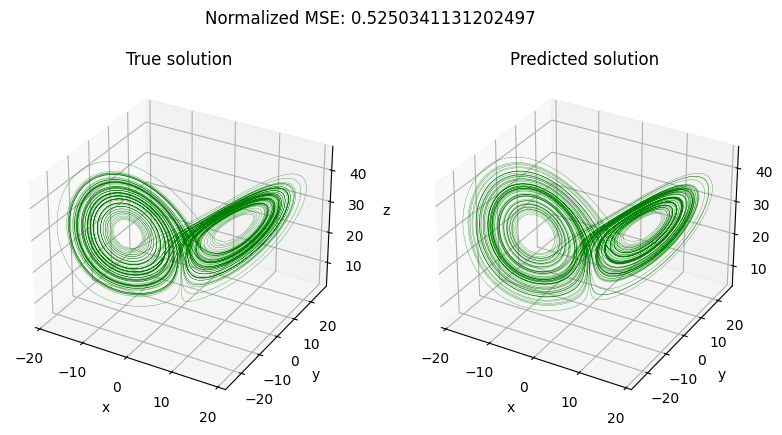

In [19]:
X_true = np.stack((x, y, z), axis=-1)
X_pred = sim
myplot3d(X_true,X_pred)

In general we don't have an accurate result over the entire time span. Let's see how far can we go ?

In [20]:
mses = []
t_sample = []
for i in range(1,len(t),100):
  mse = mean_squared_error(X_true[:i,],X_pred[:i,]) / mean_squared_error(X_true[:i,],0*X_pred[:i,])
  mses.append(mse)
  t_sample.append(t[i])

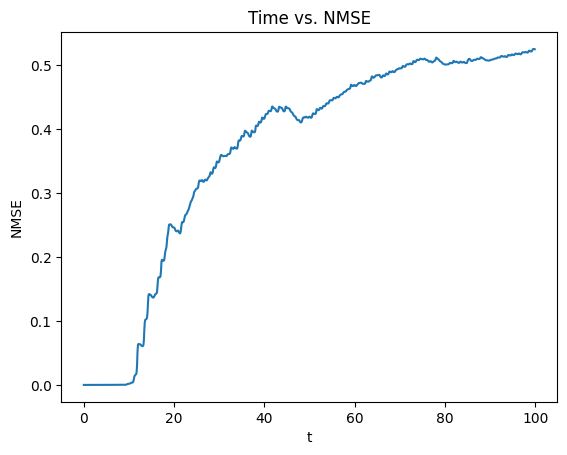

In [21]:
plt.plot(np.array(t_sample),mses)
plt.title('Time vs. NMSE')
plt.xlabel('t')
plt.ylabel('NMSE')
plt.show()

x-variable: true vs. predicted

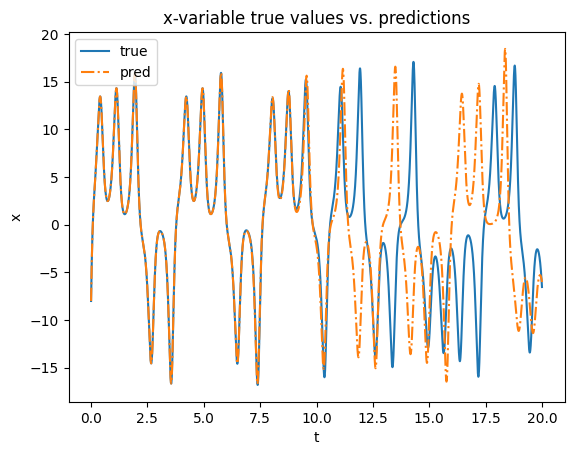

In [22]:
t_max = 20000 # Remember t could take values between 1 and 100.000
variable = 'x'
myplot(t,x,sim,t_max, variable)

y-variable: true vs. predicted

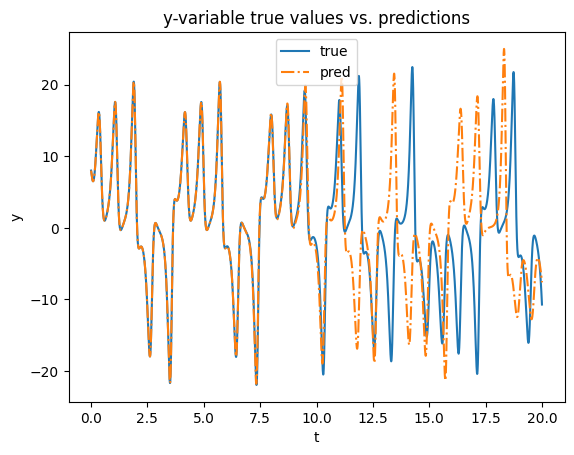

In [23]:
t_max = 20000 # Remember t could take values between 1 and 100.000
variable = 'y'
myplot(t,y,sim,t_max, variable)

z-variable: true vs. predicted

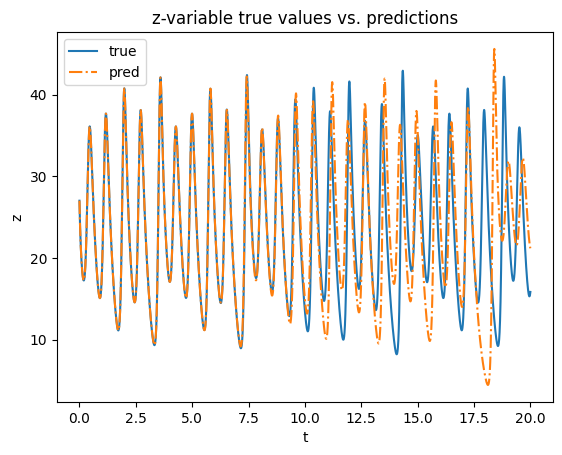

In [24]:
t_max = 20000 # Remember t could take values between 1 and 100.000
variable = 'z'
myplot(t,z,sim,t_max, variable)

But wait a second, our goal was recovering the system. Let's compute how good they are against the true ones.

In [25]:
pred_coef = model.coefficients()
print(pred_coef)

[[ 0.         -9.99908642  9.99901732  0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.         27.99160131 -0.9983031   0.          0.          0.
  -0.99976737  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.         -2.66627737  0.          0.99986385
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.        ]]


In [26]:
true_coef = [-10,10,28,-1,-1,1,-8/3]
pred_coef = pred_coef[np.nonzero(pred_coef)]

In [27]:
mean_squared_error(true_coef, pred_coef) / mean_squared_error(true_coef,0* pred_coef)

0.027044372313133606

This reflects that we actually recover a good system. 2% of error in matching the real coefficients !

## Problem

1. SINDy was originally used to discover systems of ordinary differential equations (ODEs) but was quickly extended to search partial differential equations (PDEs), since many systems exhibit dependence in both space and time. Study the paper

>Rudy, Samuel H., Steven L. Brunton, Joshua L. Proctor, and J. Nathan Kutz. “Data-driven discovery of partial differential equations.

to identify the 1D Korteweg-De Vries (kdV) equation

$$
u_t=-6 u u_x-u_{x x x}
$$

Hint: Follow the implementation [here](https://pysindy.readthedocs.io/en/latest/examples/10_PDEFIND_examples/example.html#Test-PDE-functionality-on-the-1D-kdV-equation).